In [1]:
import config_readwrite as crw
import glob
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd

from scipy import stats
import seaborn as sns
import statsmodels.api as sm
import sys

import warnings
warnings.filterwarnings("ignore")
from statsmodels.formula.api import ols

import plot_params as pp
pp.fonts()

('sans-serif', 'Arial', 18)

# config

In [2]:
CONFIG = "/wynton/home/ahituv/fongsl/EMF/config.ini"

config, cfn = crw.read(CONFIG)

RE = "/wynton/home/ahituv/fongsl/EMF/results/"
RE_DDCT = os.path.join(RE, f"*.ddCTs.tsv")

# go to datapath
os.chdir(RE)

# load data 

In [3]:
fs = glob.glob(RE_DDCT)

results = {}
for f in fs:
    results[f] = pd.read_csv(f, sep='\t') 
    

In [4]:
df = pd.concat(results.values())
df = df.loc[~df["primers"].isna()]
df.head()

,Well Position,CT,plate,primers,sample_name,rep,Experiment,Control_mean,dCT,Control_dCT_mean,ddCT,fold_change,control_gene,date
0,B1,14.908525,plate1.xls,GAPDH,Control 30' exp1,1.0,1.0,26.109299,-11.200775,-11.398504,0.197730,0.871921,ACTB,20240123
1,B2,14.369675,plate1.xls,GAPDH,Control 30' exp1,2.0,1.0,26.109299,-11.739624,-11.398504,-0.341120,1.266740,ACTB,20240123
2,B3,15.763824,plate1.xls,GAPDH,Control 30' exp1,3.0,1.0,26.109299,-10.345476,-11.398504,1.053029,0.481955,ACTB,20240123
3,B4,13.756628,plate1.xls,GAPDH,PEMF 60' exp1,1.0,1.0,26.447333,-12.690705,-11.398504,-1.292200,2.449012,ACTB,20240123
4,B5,15.132206,plate1.xls,GAPDH,PEMF 60' exp1,2.0,1.0,26.447333,-11.315127,-11.398504,0.083378,0.943845,ACTB,20240123


## format data

In [5]:
# reformat some names

# 20231115
df.loc[(df["date"]==20231115)&
      (df["primers"] == "IL6"), "primers"] = "IL6-original "

df.loc[(df["date"]==20231115)&
      (df["sample_name"] == "PEMF-physiostim 60'"), "sample_name"] = "PEMF 60' exp1"

df.loc[(df["date"]==20231115)&
      (df["sample_name"] == "PEMF-physiostim 30'"), "sample_name"] = "PEMF 30' exp1"

df.loc[(df["date"]==20231115)&
      (df["sample_name"] == "Control"), "sample_name"] = "Control 30' exp1"

df.loc[df["primers"].str.contains("HSP1A1"), "primers"] = 'HSP70A'

# 20231212
df.loc[(df["date"]==20231212)&
      (df["primers"] == "IL6"), "primers"]="IL6-2"

df.loc[(df["date"]==20231212)&
      (df["sample_name"] == "PEMF-physiostim"), "sample_name"] = "PEMF 60' exp2"

df.loc[(df["date"]==20231212)&
      (df["sample_name"] == "Control"), "sample_name"] = "Control 60' exp2"

#20231222
df.loc[(df["date"]==20231222)&
      (df["sample_name"] == "PEMF-physiostim"), "sample_name"]="PEMF 60' exp2"

df.loc[(df["date"]==20231222)&
      (df["sample_name"] == "Control"), "sample_name"] = "Control 60' exp2"

# IL-6

In [6]:
genes = ['IL6',
         'IL6-1',
         'IL6-2',
         'IL6-original '
        ]

il6 = df.loc[df["primers"].isin(genes)].copy()

il6.head()

il6[["sample_name", "date"]].drop_duplicates().sort_values(by='sample_name')

,sample_name,date
18,Control 30' exp1,20240123
96,Control 30' exp1,20231115
109,Control 60' exp2,20240123
12,Control 60' exp2,20231212
108,Control 60' exp2,20231222
108,PEMF 30' exp1,20231115
21,PEMF 60' exp1,20240123
120,PEMF 60' exp1,20231115
90,PEMF 60' exp2,20240123
111,PEMF 60' exp2,20231222


## ACTB housekeeping

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


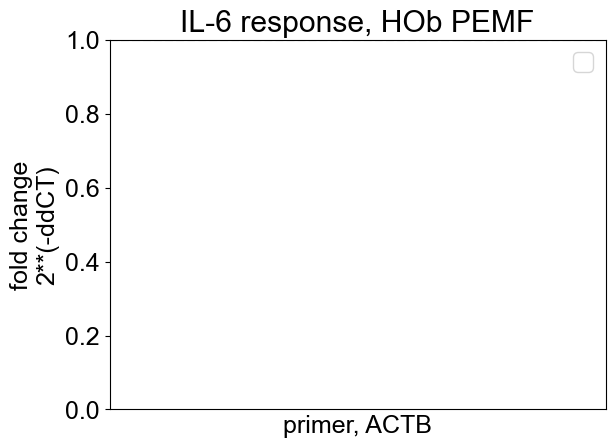

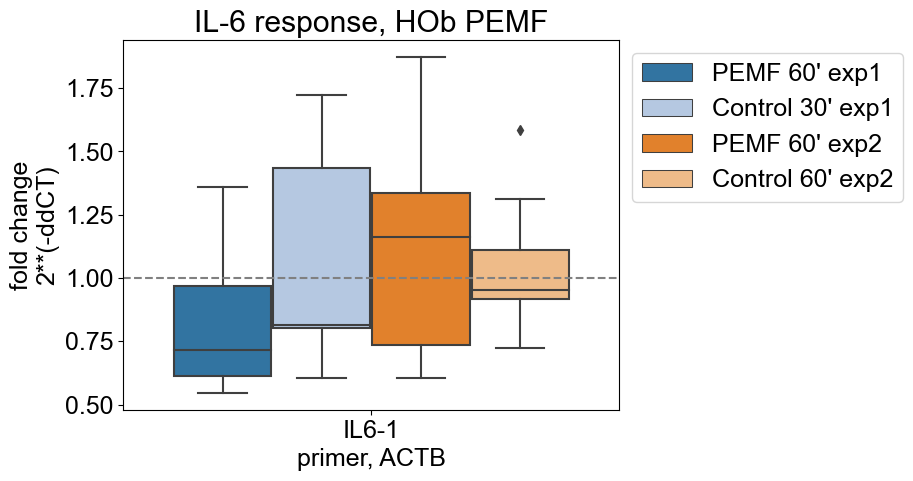

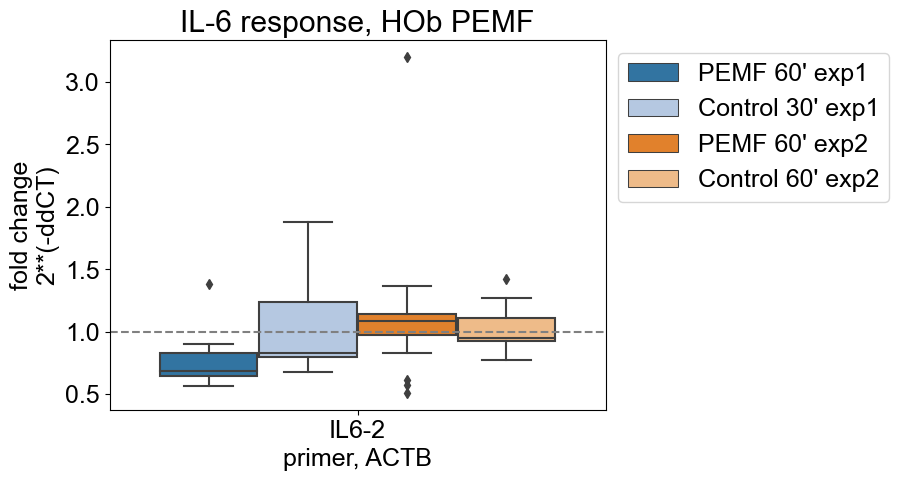

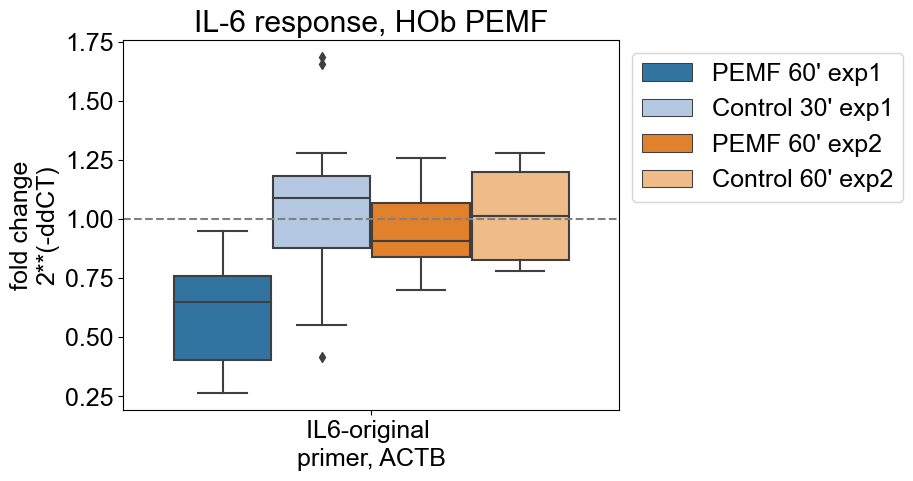

In [7]:
x = "primers"
y = "fold_change"
hue = 'sample_name'
control_gene = "ACTB"
hue_order = ["PEMF 60' exp1",
             "Control 30' exp1",
             "PEMF 60' exp2",
             "Control 60' exp2",
             ]


for gene in genes: 
    data = il6.loc[(il6["control_gene"] == control_gene) &
                   (il6["sample_name"] != "noRT") &
                   (~il6["sample_name"].str.contains("HF")&
                   (il6["primers"]== gene))
                   ].copy()

    fig, ax = plt.subplots()
    sns.boxplot(x=x, y=y, data=data,
                hue=hue,
                hue_order=hue_order,
                # showfliers=False,
                palette="tab20"
                )
    ax.legend(frameon=False)
    """
    sns.swarmplot(x=x, y=y, data=data,
                  hue=hue,
                  hue_order=hue_order,
                  dodge=True,
                  palette="tab20",
                  linewidth=1,
                  size=4,
                  legend=False

                  )
                  """
    ax.axhline(1, ls="--", color="grey")
    ax.set(ylabel="fold change\n2**(-ddCT)",
           title='IL-6 response, HOb PEMF',
           xlabel=f"primer, {control_gene}")

    plt.legend(bbox_to_anchor=(1, 1))

    out = os.path.join(RE, f"qpcr_summary_{gene}_HOB_pemf_{control_gene}.pdf")
    plt.savefig(out, bbox_inches="tight")

## GAPDH house keeping

In [ ]:
x = "primers"
y = "fold_change"
hue = 'sample_name'

hue_order = ["PEMF 60' exp1",
             "Control 30' exp1",

             # "PEMF 30' exp1",

             "PEMF 60' exp2",
             "Control 60' exp2",
             ]

control_gene = "GAPDH"
for gene in genes: 
    data = il6.loc[(il6["control_gene"] == control_gene) &
                   (il6["sample_name"] != "noRT") &
                   (~il6["sample_name"].str.contains("HF")&
                   (il6["primers"]== gene))
                   ].copy()

    fig, ax = plt.subplots()
    sns.boxplot(x=x, y=y, data=data,
                hue=hue,
                hue_order=hue_order,
                # showfliers=False,
                palette="tab20"
                )
    ax.legend(frameon=False)
    """
    sns.swarmplot(x=x, y=y, data=data,
                  hue=hue,
                  hue_order=hue_order,
                  dodge=True,
                  palette="tab20",
                  linewidth=1,
                  size=4,
                  legend=False

                  )
                  """
    ax.axhline(1, ls="--", color="grey")
    ax.set(ylabel="fold change\n2**(-ddCT)",
           title='IL-6 response, HOb PEMF',
           xlabel=f"primers, {control_gene}")

    plt.legend(bbox_to_anchor=(1, 1))

    out = os.path.join(RE, f"qpcr_summary_{gene}_HOB_pemf_{control_gene}.pdf")
    plt.savefig(out, bbox_inches="tight")

## all together 

In [9]:
palette = ["#0485d1", "#929591", "#75bbfd", "#d8dcd6"]
sns.set_style("white")

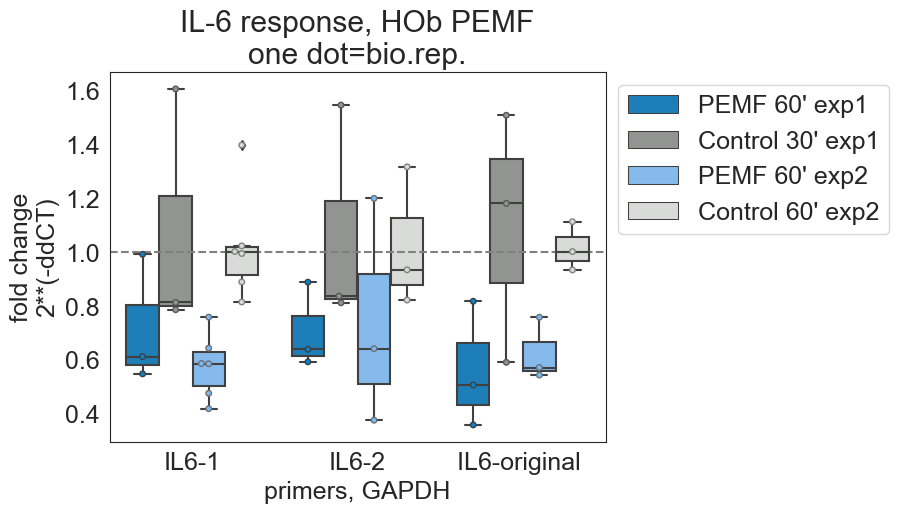

In [10]:
x = "primers"
y = "fold_change"
hue = 'sample_name'
SHOW_TECHNICAL_REPS = False

hue_order = ["PEMF 60' exp1",
             "Control 30' exp1",
             "PEMF 60' exp2",
             "Control 60' exp2",
             # "PEMF 30' exp1",
             ]

control_gene = "GAPDH"

data = il6.loc[(il6["control_gene"] == control_gene) &
               (il6["sample_name"] != "noRT") &
               (~il6["sample_name"].str.contains("HF"))
               ].copy()

if SHOW_TECHNICAL_REPS is False:
    # take the mean fold_change of technical replicates for each experiment, replicate, date
    data = data.groupby(["sample_name", "Experiment", 'rep', "date", "primers"])[
    "fold_change"].mean().reset_index()

fig, ax = plt.subplots()
sns.boxplot(x=x, y=y, data=data,
            hue=hue,
            hue_order=hue_order,
            # showfliers=False,
            palette=palette,
            )
ax.legend(frameon=False)

sns.swarmplot(x=x, y=y, data=data,
              hue=hue,
              hue_order=hue_order,
              dodge=True,
              palette=palette,
              linewidth=1,
              size=4,
              legend=False

              )

ax.axhline(1, ls="--", color="grey")

plt.legend(bbox_to_anchor=(1, 1))
if SHOW_TECHNICAL_REPS is False:
    ax.set(ylabel="fold change\n2**(-ddCT)",
       title='IL-6 response, HOb PEMF\none dot=bio.rep.',
       xlabel=f"primers, {control_gene}")

    out = os.path.join(
        RE, f"qpcr_summary_all-IL6_HOB_pemf_{control_gene}.bioreps.pdf")
else:
    ax.set(ylabel="fold change\n2**(-ddCT)",
       title='IL-6 response, HOb PEMF\none dot=tech.rep.',
       xlabel=f"primers, {control_gene}")
    out = os.path.join(RE, f"qpcr_summary_all-IL6_HOB_pemf_{control_gene}.techreps.pdf")
plt.savefig(out, bbox_inches="tight")

In [12]:
28*28

784

In [ ]:
for gene_name in genes:


    ctrl1 = data.loc[(data["sample_name"] == "Control 30' exp1") &
                     (data["primers"] == gene_name),
                     "fold_change"]

    pemf1 = data.loc[(data["sample_name"] == "PEMF 60' exp1") &
                     (data["primers"] == gene_name),
                     "fold_change"]

    ctrl2 = data.loc[(data["sample_name"] == "Control 60' exp2") &
                     (data["primers"] == gene_name),
                     "fold_change"]
    pemf2 = data.loc[(data["sample_name"] == "PEMF 60' exp2") &
                     (data["primers"] == gene_name),
                     "fold_change"]
    if len(ctrl1) > 0:
        s1, p1 = stats.mannwhitneyu(ctrl1,pemf1)
        print(gene_name, "ctrl1", s1, p1)
    if len(ctrl2) > 0:
        s2,p2 = stats.mannwhitneyu(ctrl2,pemf2)
        print(gene_name, "ctrl2", s2, p2)

# no RT

In [ ]:
no_rt = df.loc[(df["sample_name"] == "noRT") ].copy()
no_rt["CT"] =no_rt["CT"].fillna(no_rt["CT"].max())
sns.swarmplot(y= "primers",x="CT", hue='date', data=no_rt.sort_values(by="primers"), palette="tab10")
plt.legend(bbox_to_anchor=(1,1))

# HSPs

In [ ]:
genes = ["HSP70A", "HSP70C"]

hsp = df.loc[df["primers"].isin(genes)].copy()


hsp[["sample_name", "date"]].drop_duplicates().sort_values(by='sample_name')

## actb

In [ ]:
x = "primers"
y = "fold_change"
hue = 'sample_name'

SHOW_TECHNICAL_REPS = False

hue_order = [
    "PEMF 60' exp1",
    "Control 30' exp1",
    "PEMF 60' exp2",
    "Control 60' exp2",

]

control_gene = "ACTB"
data = hsp.loc[(hsp["control_gene"] == control_gene) &
               (hsp["sample_name"] != "noRT") &
               (~hsp["sample_name"].str.contains("HF"))
               ].copy()


if SHOW_TECHNICAL_REPS is False:
    # take the mean fold_change of technical replicates for each experiment, replicate, date
    data = data.groupby(["sample_name", "Experiment", 'rep', "date", "primers"])[
    "fold_change"].mean().reset_index()

fig, ax = plt.subplots(figsize=(8,8))
sns.boxplot(x=x, y=y, data=data,
            hue=hue,
            hue_order=hue_order,
            # showfliers=False,
            palette=palette
            )
ax.legend(frameon=False)

sns.swarmplot(x=x, y=y, data=data,
              hue=hue,
              hue_order=hue_order,
              dodge=True,
              palette=palette,
              linewidth=1,
              size=4,
              legend=False

              )

ax.axhline(1, ls="--", color="grey")

plt.legend(bbox_to_anchor=(1, 1))
if SHOW_TECHNICAL_REPS is False:
    ax.set(ylabel="fold change\n2**(-ddCT)",
       title='HSP response, HOb PEMF\none dot=bio.rep.',
       xlabel=f"primers, {control_gene}")

    out = os.path.join(
        RE, f"qpcr_summary_all-hsp_HOB_pemf_{control_gene}.bioreps.pdf")
else:
    ax.set(ylabel="fold change\n2**(-ddCT)",
       title='HSP response, HOb PEMF\none dot=tech.rep.',
       xlabel=f"primers, {control_gene}")
    out = os.path.join(RE, f"qpcr_summary_all-hsp_HOB_pemf_{control_gene}.techreps.pdf")


plt.savefig(out, bbox_inches="tight")

In [ ]:
for gene_name in genes:


    ctrl1 = data.loc[(data["sample_name"] == "Control 30' exp1") &
                     (data["primers"] == gene_name),
                     "fold_change"]

    pemf1 = data.loc[(data["sample_name"] == "PEMF 60' exp1") &
                     (data["primers"] == gene_name),
                     "fold_change"]

    ctrl2 = data.loc[(data["sample_name"] == "Control 60' exp2") &
                     (data["primers"] == gene_name),
                     "fold_change"]
    pemf2 = data.loc[(data["sample_name"] == "PEMF 60' exp2") &
                     (data["primers"] == gene_name),
                     "fold_change"]
    if len(ctrl1) > 0:
        s1, p1 = stats.mannwhitneyu(ctrl1,pemf1)
        print(gene_name, "ctrl1", s1, p1)
    if len(ctrl2) > 0:
        s2,p2 = stats.mannwhitneyu(ctrl2,pemf2)
        print(gene_name, "ctrl2", s2, p2)

In [ ]:
x = "primers"
y = "fold_change"
hue = 'sample_name'

hue_order = ["Control 30' exp1",
             "Control 60' exp2",
             # "PEMF 30' exp1",
             "PEMF 60' exp1",
             "PEMF 60' exp2"]

control_gene = "GAPDH"
data = hsp.loc[(hsp["control_gene"] == control_gene) &
               (hsp["sample_name"] != "noRT") &
               (~hsp["sample_name"].str.contains("HF"))
               ].copy()

fig, ax = plt.subplots()
sns.boxplot(x=x, y=y, data=data,
            hue=hue,
            hue_order=hue_order,
            # showfliers=False,
            palette="tab20"
            )
ax.legend(frameon=False)

sns.swarmplot(x=x, y=y, data=data,
              hue=hue,
              hue_order=hue_order,
              dodge=True,
              palette="tab20",
              linewidth=1,
              size=4,
              legend=False

              )

ax.axhline(1, ls="--", color="grey")
ax.set(ylabel="fold change\n2**(-ddCT)",
       title='HSP response\nHOb PEMF', 
      xlabel=f"primers, {control_gene}")

plt.legend(bbox_to_anchor=(1, 1))

out = os.path.join(RE, f"qpcr_summary_hsp_HOB_pemf_{control_gene}.pdf")
plt.savefig(out, bbox_inches="tight")

In [ ]:
RE